In [1]:
import cv2
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob

from camera_calibration.camera_calibration import read_calibration, undistort_image
from color_and_gradient import pipeline
from warp_perspective.warp_perspective import read_warp, warp_image

import sys
sys.path.append('../')
from utils.plot_utils import plt_imlist

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Read params

In [2]:
int_params = read_calibration("camera_calibration/camera_intrinsics.pkl")
warp_params = read_warp("warp_perspective/perspective.pkl")

In [3]:
def draw_lane(img, Minv, left_fit, right_fit, left_curverad, right_curverad, offset):
    ploty = np.array(np.linspace(0, img.shape[0]-1, img.shape[0]))
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int32(pts), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # Add ROC info
    cv2.putText(result, f"ROC Left:  {int(left_curverad)}m", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 255))
    cv2.putText(result, f"ROC Right: {int(right_curverad)}m", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 255))

    # Shift from center
    if offset >= 0:
        cv2.putText(result, f"Shifted left to: {offset:.02f}m", (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 255))
    else:
        cv2.putText(result, f"Shifted right to: {(-1)*offset:.02f}m", (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (100, 255, 255))

    #plt.imshow(result)
    return result

In [4]:
class Line():
    def __init__(self):
        self.h = 720
        # average over how many frames
        self.n_frames = 10
        # was the line detected in the last iteration?
        self.detected = False     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for last N frames
        self.recent_fits = []
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None  

        self.y_eval = 719
        self.ym_per_pix = 30/720
        self.xm_per_pix = 3.7/720
        
    def update(self, cur_x, cur_y, cur_fit):
        self.ally = cur_x
        self.allx = cur_y
        self.diffs = cur_fit - self.current_fit
        self.current_fit = cur_fit 

        # Average polynomial coefficients
        self.recent_fits.append(cur_fit)
        if len(self.recent_fits) > self.n_frames:
            self.recent_fits = self.recent_fits[-self.n_frames:]
        self.best_fit = np.average(np.array(self.recent_fits), axis=0)

        # Calculate Radius of Curvature
        A = self.xm_per_pix * self.best_fit[0] / (self.ym_per_pix ** 2)
        B = self.xm_per_pix * self.best_fit[1] / self.ym_per_pix
        self.radius_of_curvature = ((1 + (2*A*self.y_eval + B)**2)**1.5) / np.absolute(2*A)

In [5]:
class LaneFinder():
    def __init__(self):
        self.rlane = Line()
        self.llane = Line()
        self.int_params = read_calibration("camera_calibration/camera_intrinsics.pkl")
        self.warp_params = read_warp("warp_perspective/perspective.pkl")
        self.warp_params_inv = np.linalg.inv(self.warp_params)
        self.nwindows = 9
        self.window_margin = 100 
        self.window_minpix = 50
        self.poly_margin = 100

        self.y_eval = 719

        self.ym_per_pix = 30/720
        self.xm_per_pix = 3.7/720

        self.lane_width = 3.7 #m
        self.lane_width_margin = 1.0 #m
        
    def detected(self):
        return self.rlane.detected and self.llane.detected
    
    def undistort_image(self, img):
        return undistort_image(img, self.int_params)
    
    def threshold_image(self, img):
        return pipeline(img, s_thresh=(90, 255), sx_thresh=(10, 100))
    
    def warp_image(self, img):
        return warp_image(img, self.warp_params)
    
    def find_lane_pixels(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.window_margin
            win_xleft_high = leftx_current + self.window_margin
            win_xright_low = rightx_current - self.window_margin
            win_xright_high = rightx_current + self.window_margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.window_minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.window_minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img

    def fit_polynomial(self, img_warped, ret_img=False):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(img_warped)

        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Try Generate x and y values for plotting
        ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0] )
        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            ret = True
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
            ret = False

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')

        #print(len(leftx), len(rightx))

        if ret_img is True:
            return ret, leftx, lefty, left_fit, rightx, righty, right_fit, out_img
        else:
            return ret, leftx, lefty, left_fit, rightx, righty, right_fit
        
    def fit_poly(self, leftx, lefty, rightx, righty):
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
        return left_fit, right_fit
    
    def search_around_poly(self, binary_warped, left_fit, right_fit):
        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Set the area of search based on activated x-values within the +/- margin of our polynomial function 
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - self.poly_margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + self.poly_margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - self.poly_margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + self.poly_margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit new polynomials
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        return leftx, lefty, left_fit, rightx, righty, right_fit

    def measure_curvature(self, left_fit, right_fit, y_eval):
        # Calculation of R_curve (radius of curvature)
        A_l = self.xm_per_pix * left_fit[0] / (self.ym_per_pix ** 2)
        B_l = self.xm_per_pix * left_fit[1] / self.ym_per_pix
        A_r = self.xm_per_pix * right_fit[0] / (self.ym_per_pix ** 2)
        B_r = self.xm_per_pix * right_fit[1] / self.ym_per_pix
        left_curverad = ((1 + (2*A_l*y_eval + B_l)**2)**1.5) / np.absolute(2*A_l)
        right_curverad = ((1 + (2*A_r*y_eval + B_r)**2)**1.5) / np.absolute(2*A_r)
        
        return left_curverad, right_curverad

    def measure_lane(self, left_fit, right_fit):
        "Calculate lane width and relative car postion in lane" 
        left_pos = left_fit[0]*self.y_eval**2 + left_fit[1]*self.y_eval + left_fit[2]
        right_pos = right_fit[0]*self.y_eval**2 + right_fit[1]*self.y_eval + right_fit[2]
        mid_pos = (left_pos + right_pos)/2
        return self.xm_per_pix *(right_pos - left_pos), self.xm_per_pix * (640 - mid_pos)
    
    def process(self, img):
        img_rect = self.undistort_image(img)
        img_thresh = self.threshold_image(img_rect)
        img_warped = self.warp_image(img_thresh)
        
        if self.detected() is False:
            ret, leftx, lefty, left_fit, rightx, righty, right_fit = self.fit_polynomial(img_warped)
        else:
            leftx, lefty, left_fit, rightx, righty, right_fit = self.search_around_poly(img_warped, self.llane.current_fit, self.rlane.current_fit)
        
        self.llane.update(leftx, lefty, left_fit)
        self.rlane.update(rightx, righty, right_fit)

        left_curverad, right_curverad = self.measure_curvature(self.llane.best_fit, self.rlane.best_fit, self.y_eval)

        lane_width, offset = self.measure_lane(self.llane.best_fit, self.rlane.best_fit)
        if lane_width < self.lane_width - self.lane_width_margin and lane_width > self.lane_width + self.lane_width_margin:
            self.llane.detected = False
            self.rlane.detected = False
        
        #plt.figure()
        return draw_lane(img_rect, self.warp_params_inv, self.llane.best_fit, self.rlane.best_fit, left_curverad, right_curverad, offset)     

<Figure size 432x288 with 0 Axes>

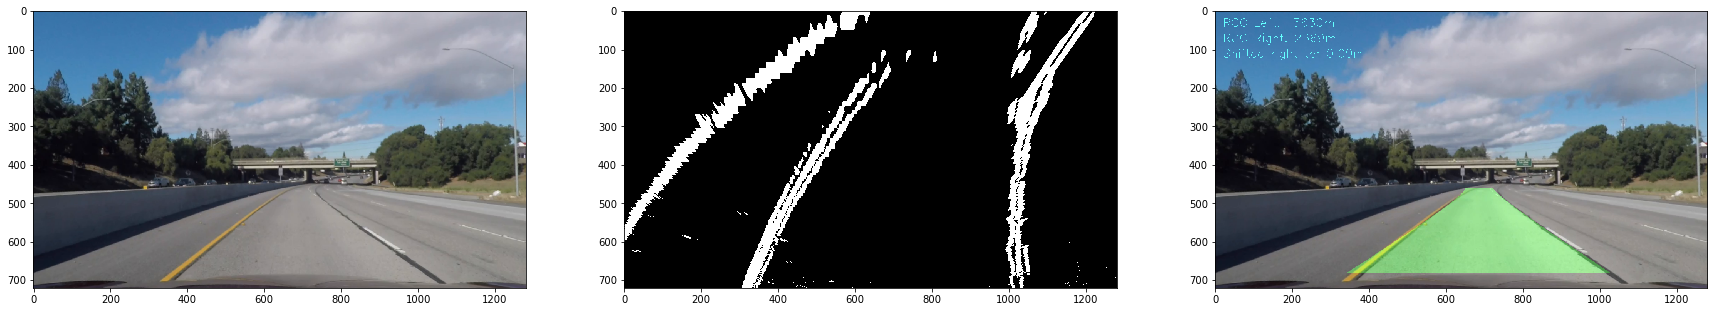

<Figure size 2160x1080 with 0 Axes>

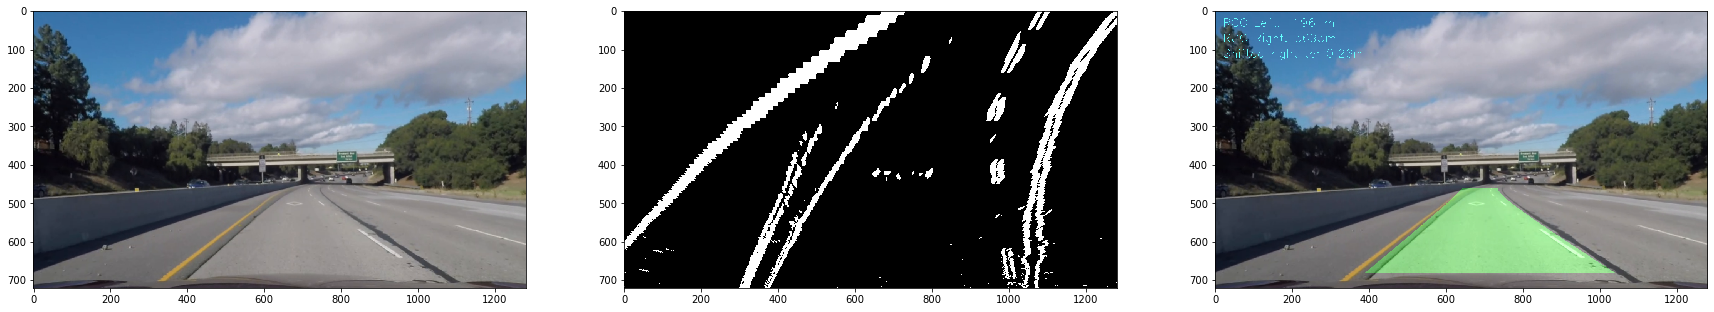

<Figure size 2160x1080 with 0 Axes>

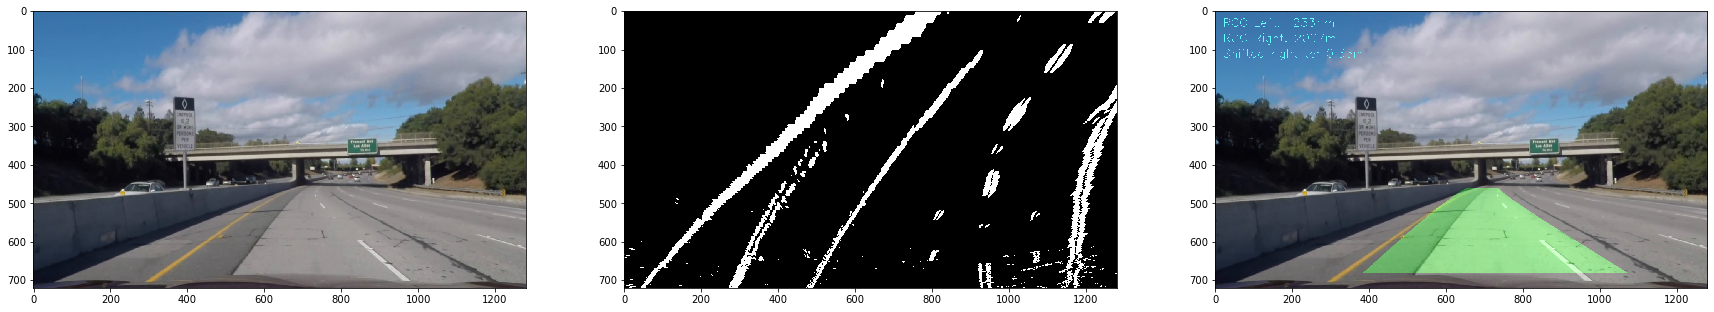

<Figure size 2160x1080 with 0 Axes>

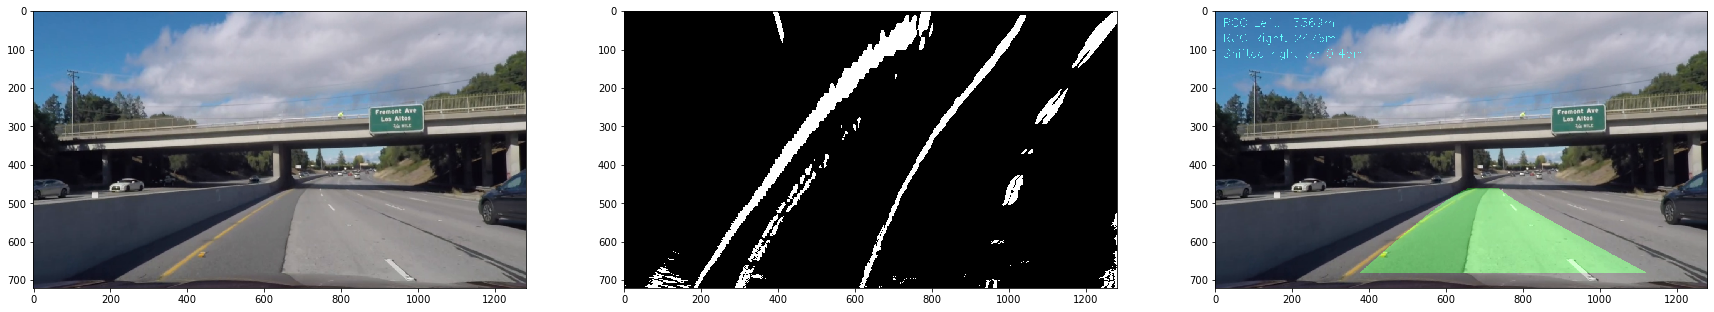

<Figure size 2160x1080 with 0 Axes>

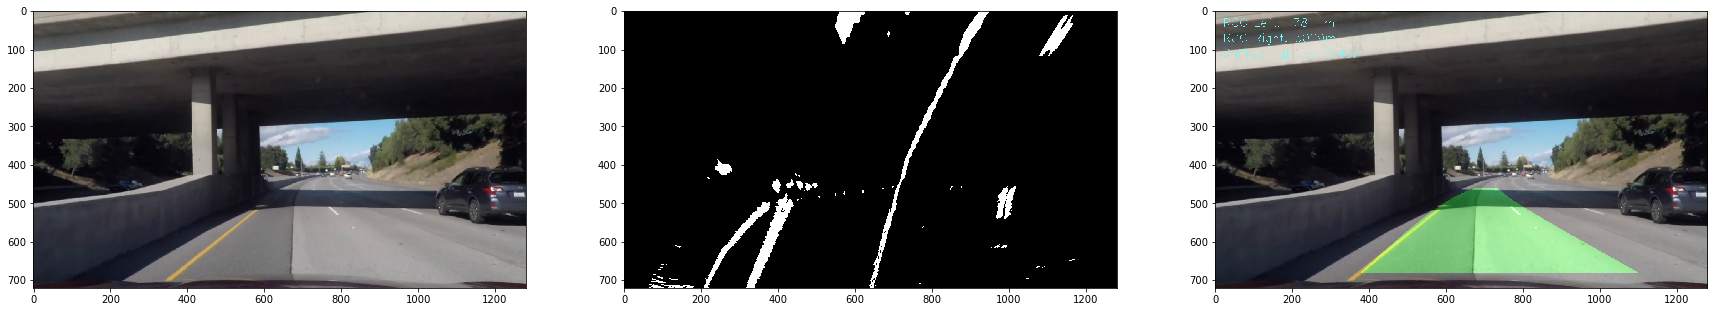

<Figure size 2160x1080 with 0 Axes>

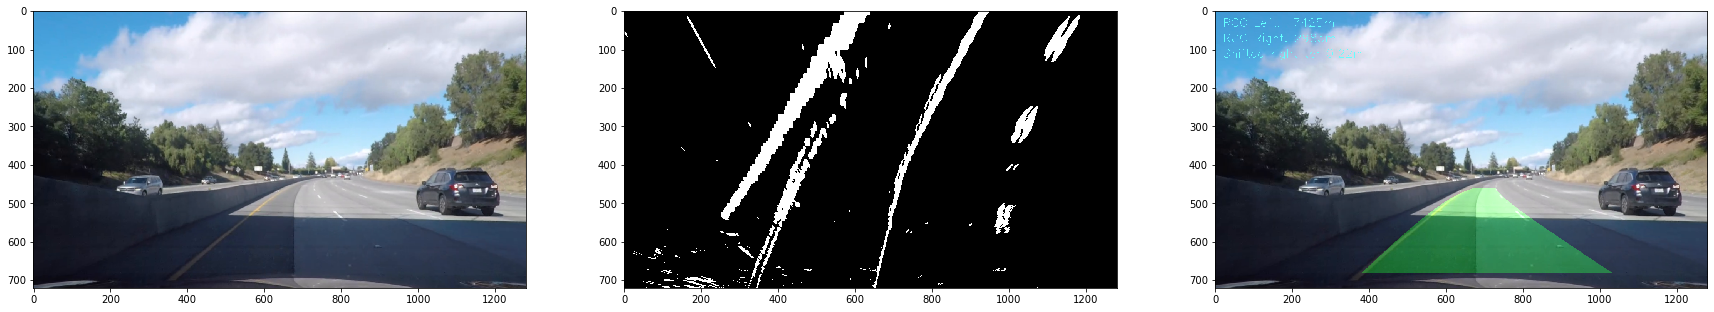

<Figure size 2160x1080 with 0 Axes>

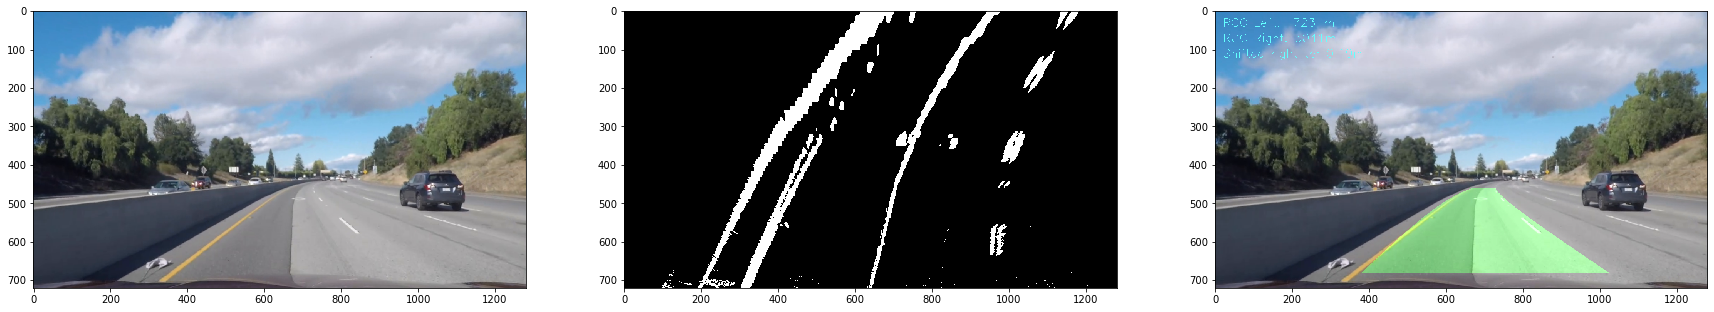

In [6]:
video = VideoFileClip('test_videos/challenge_video.mp4')
LF = LaneFinder()

for i in range(0,7):
    img = video.get_frame(i)
    img_rect = LF.undistort_image(img)
    img_thresh = LF.threshold_image(img_rect)
    img_warped = LF.warp_image(img_thresh)
    _, _, _, _, _, _, _, fit_img = LF.fit_polynomial(img_warped, ret_img=True)
    ret = LF.process(img)
    plt_imlist([img_rect, img_warped, ret])

In [7]:
LF = LaneFinder()

images = glob.glob("test_images/**.jpg")

for image in images[-1:]:
    img = mpimg.imread(image)
    LF.process(img)

<Figure size 2160x1080 with 0 Axes>

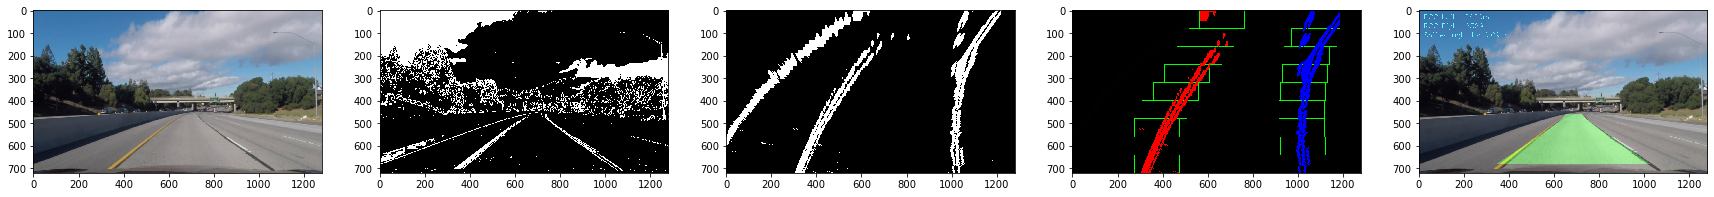

<Figure size 2160x1080 with 0 Axes>

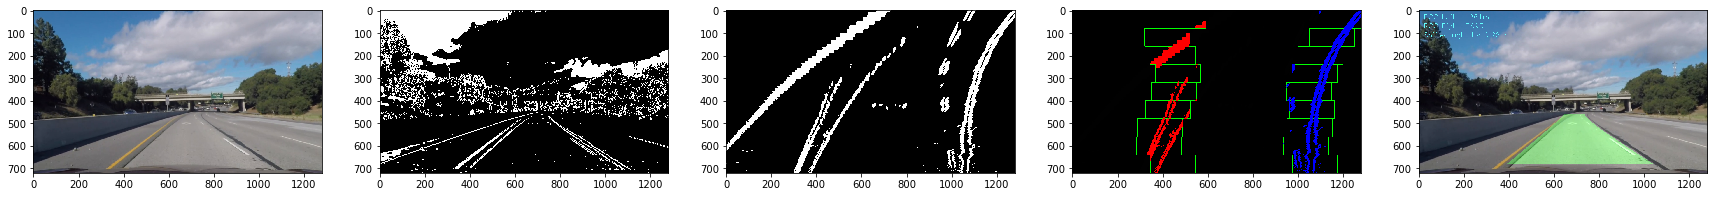

<Figure size 2160x1080 with 0 Axes>

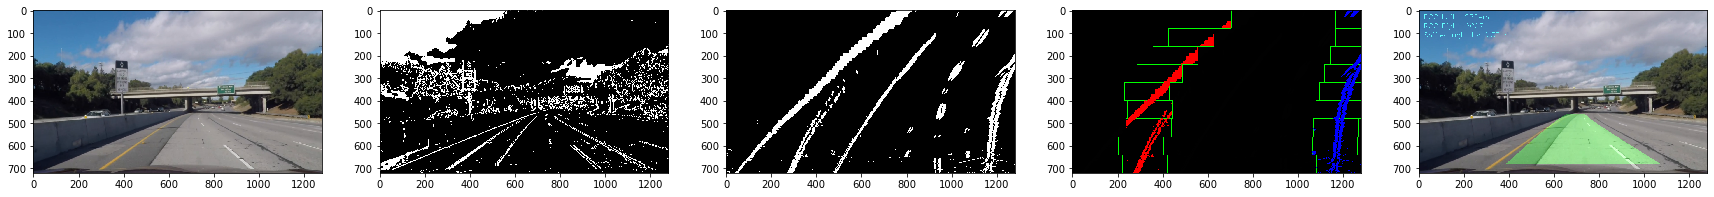

<Figure size 2160x1080 with 0 Axes>

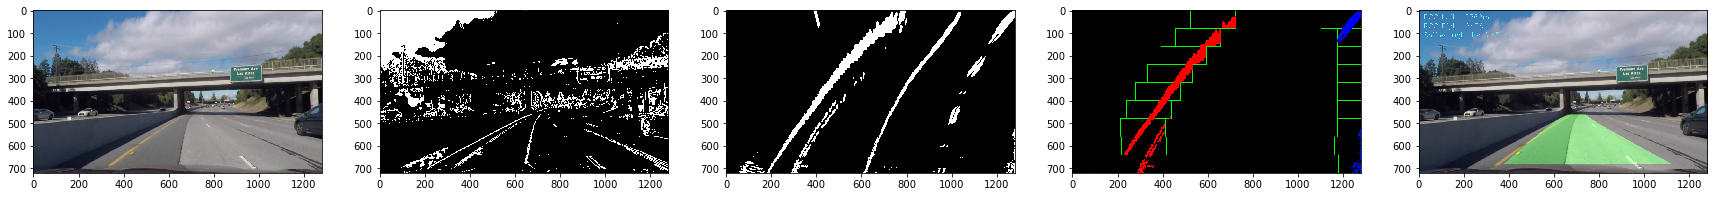

<Figure size 2160x1080 with 0 Axes>

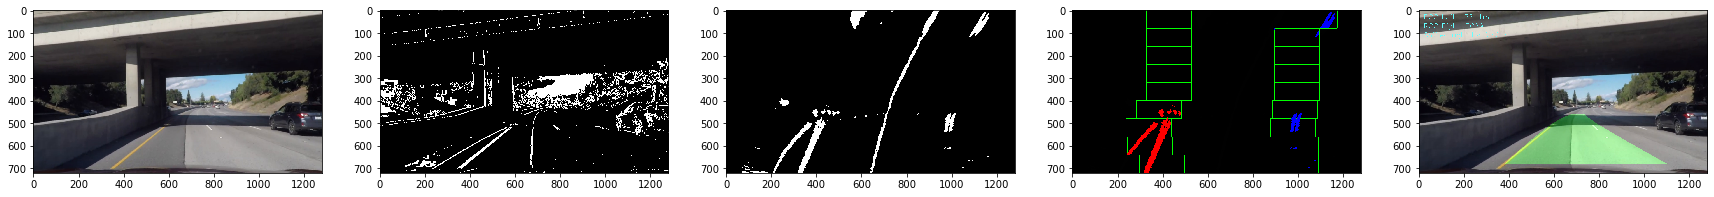

<Figure size 2160x1080 with 0 Axes>

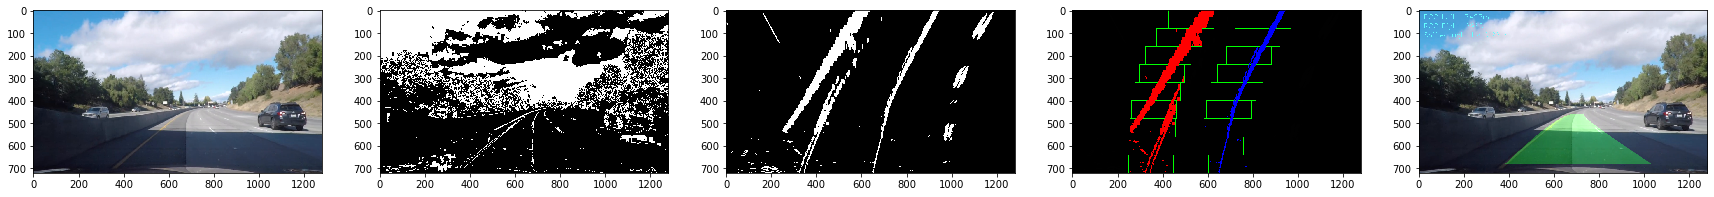

<Figure size 2160x1080 with 0 Axes>

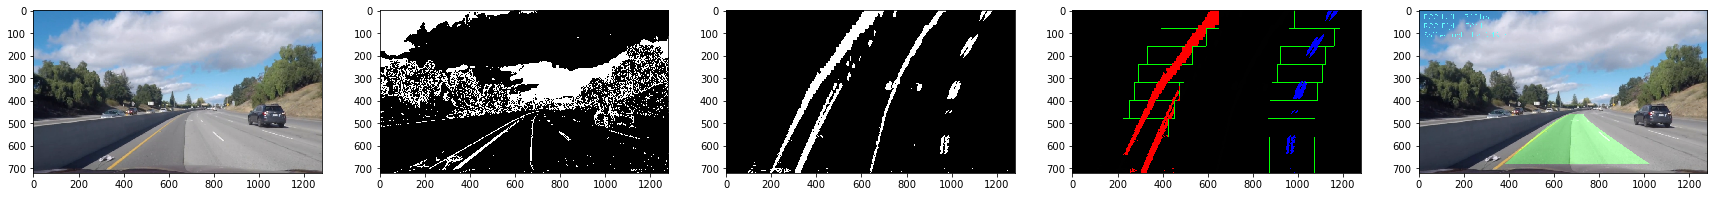

In [8]:
video = VideoFileClip('test_videos/challenge_video.mp4')

LF = LaneFinder()
for i in range(0,7):
    img = video.get_frame(i)
    img_rect = LF.undistort_image(img)
    img_thresh = LF.threshold_image(img_rect)
    img_warped = LF.warp_image(img_thresh)
    _, _, _, _, _, _, _, out_img = LF.fit_polynomial(img_warped, ret_img=True)
    ret = LF.process(img)
    plt_imlist([img_rect, img_thresh, img_warped, out_img, ret])

In [9]:
white_output = 'output_video.mp4'
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(LF.process).subclip(0, 10)
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|          | 3/250 [00:00<00:15, 16.35it/s, now=None]

Moviepy - Building video output_video.mp4.
Moviepy - Writing video output_video.mp4



Moviepy - Done !
Moviepy - video ready output_video.mp4
CPU times: user 50.6 s, sys: 7.98 s, total: 58.6 s
Wall time: 14 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))